# Data Preprocessing
### Nhóm sẽ xử lý các entity khác nhau rồi lưu dữ liệu đã process và 3 file là `item`, `purchase` và `user`
---
**Dựa trên nội dung tiền xử lý dữ liệu, tiến hành các thao tác:**

**Task 1**: Loại bỏ các cột mà nhóm nghĩ là không cần thiết.

**Task 2**: Xử lý NULL, Xử lý Outlier

**Task 3**: Phân tích tương đồng và xác định xem các thuộc tính tương tự nhau. Từ đó loại bỏ đặc trưng thừa.

**Task 4**: Chuẩn hóa dữ liệu (nếu có), biến đổi dữ liệu

**Task 5**: Nhóm hãy suy nghĩ xem, với bài toán dự đoán mua hàng, ta có thể tạo mới những đặc trưng nào. Sau đó tiến hành rút trích thêm các đặc trưng. Task này rất quan trọng vì ảnh hưởng hiệu quả của hệ thống.

In [1]:
import glob
import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy import stats as ss
import sys
from datetime import datetime

In [2]:
path_to_items = "../data/sales_pers.item_chunk_0.parquet"
path_to_purchases = "../data/sales_pers.purchase_history_daily_chunk_*.parquet"
path_to_users = "../data/sales_pers.user_chunk_*.parquet"

item_df = pl.scan_parquet(path_to_items)
user_df = pl.scan_parquet(glob.glob(path_to_users))
purchase_df = pl.scan_parquet(glob.glob(path_to_purchases))

In [3]:
item_df.collect_schema().names()

['p_id',
 'item_id',
 'price',
 'category_l1_id',
 'category_l1',
 'category_l2_id',
 'category_l2',
 'category_l3_id',
 'category_l3',
 'category_id',
 'category',
 'description',
 'brand',
 'manufacturer',
 'creation_timestamp',
 'is_deleted',
 'created_date',
 'updated_date',
 'sync_status_id',
 'last_sync_date',
 'sync_error_message',
 'image_url',
 'gender_target',
 'age_group',
 'item_type',
 'gp',
 'weight',
 'color',
 'size',
 'origin',
 'volume',
 'material',
 'sale_status',
 'description_new']

# **Task 1: Loại bỏ các cột mà nhóm nghĩ là không cần thiết.**

## **1. Data Frame: Item**

In [4]:
# Các cột metadata, sync, và các cột category cấp cao không cần thiết
cols_to_drop = [
    # Metadata/Sync
    "creation_timestamp",
    "created_date",
    "updated_date",
    "sync_status_id",
    "last_sync_date",
    "sync_error_message",
    
    # Category (chỉ giữ 'category_l1')
    "category_l1_id",
    "category_l2_id",
    "category_l2",
    "category_l3_id",
    "category_l3",
    "category_id",
    "category",
    
    # Phi cấu trúc / Không liên quan
    "description",
    "description_new",
    "image_url",
    "manufacturer",  # Giữ 'brand'
    
    # Dữ liệu vật lý (thiếu nhiều)
    "gp",
    "weight",
    "volume",
    "color",
    "size",
    "origin",
    "material",

    # Dữ liệu đơn nhất (cùng một giá trị ở các hàng)
    "is_deleted",

    # Trùng với item_id
    "p_id"
]

item_df = item_df.drop(cols_to_drop)
print(f"Số cột còn lại: {len(item_df.collect_schema().names())}")
print("---")
print("Các cột còn lại trong item_df:")
print(item_df.collect_schema().names())

Số cột còn lại: 8
---
Các cột còn lại trong item_df:
['item_id', 'price', 'category_l1', 'brand', 'gender_target', 'age_group', 'item_type', 'sale_status']


## **2. Data Frame: Purchase**

In [5]:
# Các cột đề xuất bỏ cho purchase_df
cols_to_drop_purchase = [
    "user_id",       # Mã hash k tiện bằng customer_id => Dư thừa
    "event_value",   # Dư thừa (đã có quantity)
    "event_type",    # Hằng giá trị "Purchase" nên k ảnh hưởng tới output
    "created_date",  # Metadata
    "updated_date",  # Metadata
    "is_deleted"     # Cột cờ (sẽ lọc trước)
]

purchase_df = purchase_df.drop(cols_to_drop_purchase)
print(f"Số cột còn lại: {len(purchase_df.columns)}")
print("---")
print("Các cột còn lại trong purchase_df:")
print(purchase_df.columns)

Số cột còn lại: 10
---
Các cột còn lại trong purchase_df:
['timestamp', 'item_id', 'price', 'date_key', 'quantity', 'customer_id', 'channel', 'payment', 'location', 'discount']


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\1762199951.py:12: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(f"Số cột còn lại: {len(purchase_df.columns)}")
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\1762199951.py:15: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(purchase_df.columns)


## **3. Data Frame: User**

In [6]:
# Các cột đề xuất bỏ cho user_df
cols_to_drop_user = [
    # Metadata
    "created_date",
    "updated_date",
    "sync_status_id",
    "last_sync_date",
    "sync_error_message",
    
    # Dư thừa
    "user_id",       # Giữ customer_id
    "location_name", # Giữ location (ID)
    "install_date",  # Giữ timestamp
    "install_app",
    
    # Cột lọc
    "is_deleted"
]

user_df = user_df.drop(cols_to_drop_user)
print(f"Số cột còn lại: {len(user_df.columns)}")
print("---")
print("Các cột còn lại trong user_df:")
print(user_df.columns)

Số cột còn lại: 8
---
Các cột còn lại trong user_df:
['customer_id', 'gender', 'location', 'province', 'membership', 'timestamp', 'region', 'district']


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\2368082685.py:21: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(f"Số cột còn lại: {len(user_df.columns)}")
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\2368082685.py:24: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(user_df.columns)


# **Task 2: Xử lý NULL, Xử lý Outlier**

### Function for checking and handling missing values

In [7]:
import polars as pl

def null_count(df):
    """
    Đếm tổng số dòng, sau đó chạy MỘT query duy nhất
    để đếm 'null' và 'Không xác định' cho tất cả các cột.
    """
    # Sử dụng .lazy()
    d = df.lazy()
    
    # 1. Lấy tổng số dòng
    row_count = d.select(pl.len()).collect().item()
    
    if row_count == 0:
        print("DataFrame rỗng.")
        return

    print(f"Tổng số dòng (entries): {row_count:,.0f}")
    
    # 2. Tạo một list các biểu thức (expressions)
    exprs_to_run = []
    
    # Lấy danh sách cột từ schema
    cols_to_check = d.collect_schema().names()
    
    for c in cols_to_check:
        # Đếm null
        exprs_to_run.append(
            pl.col(c).is_null().sum().alias(f"{c}__null_count")
        )
        # Đếm 'Không xác định' (chỉ cho cột chuỗi/categorical)
        if d.schema[c] in [pl.Utf8, pl.Categorical]:
             exprs_to_run.append(
                (pl.col(c) == 'Không xác định').sum().alias(f"{c}__kxd_count")
            )

    # 3. Chạy 1 LƯỢT .collect() DUY NHẤT
    all_counts = d.select(exprs_to_run).collect()

    print("\n--- Báo cáo giá trị thiếu ('Không xác định' hoặc Null) ---")
    # In tiêu đề bảng
    print(f"{'Cột':<18} | {'% Thiếu':<10} | {'Tổng số thiếu':<15} | {'(Là Null)':<12} | {'(Là KXD)':<15}")
    print("-" * 80)

    # 4. In kết quả từ DataFrame 'all_counts' đã thu thập
    for c in cols_to_check:
        
        # Lấy giá trị null
        null2_count = all_counts.item(0, f"{c}__null_count")
        
        # Lấy giá trị 'Không xác định'
        null1_count = 0
        kxd_col_name = f"{c}__kxd_count"
        if kxd_col_name in all_counts.columns:
            null1_count = all_counts.item(0, kxd_col_name)

        # Tính toán tổng
        total_null_count = null1_count + null2_count
        
        if total_null_count > 0:
            null_percent = (total_null_count / row_count) * 100
            
            # In dòng kết quả
            print(f"{c:<18} | {null_percent:>9.2f}% | {total_null_count:>14,.0f} | {null2_count:>11,.0f} | {null1_count:>14,.0f}")

## **1. Data Frame: Item**

#### Ở phần EDA, nhóm cũng đã đưa ra các phần trăm các giá trị null trong `item_df` như sau:

| Thuộc tính (Field) | Tỷ lệ null / "Không xác định"(%) |
|--------------------|----------------------|
| brand              | 20.05%               |
| gender_target      | 66.00%               |
| age_group          | 57.85%               |
| item_type          | 35.93%               |
| color              | 97.35%               |
| size               | 91.86%               |
| origin             | 82.79%               |
| material           | 90.24%               |

Với biến `price`, nhóm quyết định chưa xử lý outlier ở bước này vì giá cao thường là sản phẩm cao cấp như `Xe đẩy Combi` có mức giá lên tới 20 triệu

Vì vậy, nhóm sẽ giữ nguyên biến `price` để bảo toàn thông tin hành vi, đồng thời qua task 5 sẽ xây dựng thêm feature mới `price_distribution` để nắm bắt phân khúc mua hàng một cách rõ ràng hơn.

In [8]:
cols_to_impute_simple = [
    "brand",
    "gender_target",
    "age_group"
]

impute_expressions = []
for col_name in cols_to_impute_simple:
    replacement_value = f"Unknown_{col_name.replace('_target', '')}"
    expr = (
        pl.when(pl.col(col_name) == "Không xác định")
          .then(pl.lit(replacement_value))
          .otherwise(pl.col(col_name))
          .fill_null(pl.lit(replacement_value))
          .alias(col_name)
    )
    impute_expressions.append(expr)

item_df = item_df.with_columns(impute_expressions)

- Sau khi `brand` đã sạch, nhóm sẽ tạo một bảng tra cứu (lookup table) để tìm `item_type` phổ biến nhất cho mỗi `brand`.

- Nhóm sẽ dùng bảng tra cứu này để lấp đầy 5.3 triệu giá trị `Unknown_item_type`, "cứu" lại các dữ liệu bị thiếu.

In [9]:
# 1. Tạo bảng tra cứu (dùng item_df đã clean brand từ Cell 1)
brand_to_item_type_lookup = item_df.lazy().filter(
    (pl.col("item_type") != "Không xác định") & (pl.col("item_type").is_not_null())
).group_by("brand").agg(
    pl.col("item_type").mode().first().alias("most_common_item_type")
).filter(
    pl.col("most_common_item_type").is_not_null()
)

# 2. Join lazy df với lazy lookup
item_df = item_df.join(
    brand_to_item_type_lookup,
    on="brand",
    how="left"
)

# 3. Áp dụng logic lấp đầy
item_df = item_df.with_columns(
    pl.when(
        (pl.col("item_type") == "Không xác định") | (pl.col("item_type").is_null())
    )
    .then(pl.col("most_common_item_type")) # Lấy từ brand lookup
    .otherwise(pl.col("item_type"))
    .fill_null(pl.lit("Unknown_item_type")) # Nếu brand cũng unknown -> Unknown
    .alias("item_type")
).drop("most_common_item_type") # Xóa cột tra cứu

print("Đã impute 'item_type' dựa trên 'brand'.")
print("--- ✅ ĐÃ HOÀN THÀNH XỬ LÝ item_df (Task 2) ---")

Đã impute 'item_type' dựa trên 'brand'.
--- ✅ ĐÃ HOÀN THÀNH XỬ LÝ item_df (Task 2) ---


## **2. Data Frame: Purchase**

In [10]:
null_count(purchase_df)

Tổng số dòng (entries): 35,729,825


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\363589887.py:32: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  if d.schema[c] in [pl.Utf8, pl.Categorical]:



--- Báo cáo giá trị thiếu ('Không xác định' hoặc Null) ---
Cột                | % Thiếu    | Tổng số thiếu   | (Là Null)    | (Là KXD)       
--------------------------------------------------------------------------------
channel            |      0.00% |            119 |           0 |            119
payment            |      0.93% |        331,952 |           0 |        331,952


In [11]:
# 1. Lọc bỏ 119 dòng có channel = "Không xác định"
original_count = purchase_df.select(pl.len()).collect().item() # Lấy số dòng gốc

purchase_df = purchase_df.filter(
    pl.col("channel") != "Không xác định"
)

new_count_1 = purchase_df.select(pl.len()).collect().item()
print(f"Đã lọc bỏ {original_count - new_count_1} dòng 'KXD' từ cột 'channel'.")

# 2. Điền giá trị cho 331,952 dòng 'KXD' trong cột 'payment'
replacement_value = "Unknown_Payment"

purchase_df = purchase_df.with_columns(
    pl.when(pl.col("payment") == "Không xác định")  
      .then(pl.lit(replacement_value))            
      .otherwise(pl.col("payment"))               
      .alias("payment")                           
)

print(f"Đã điền giá trị '{replacement_value}' cho các dòng 'KXD' trong cột 'payment'.")

Đã lọc bỏ 119 dòng 'KXD' từ cột 'channel'.
Đã điền giá trị 'Unknown_Payment' cho các dòng 'KXD' trong cột 'payment'.


### **`Price`**

In [12]:
# --- Bước 1: Tính Q1, Q3, và tổng số lượng (Pass 1) ---
stats = purchase_df.lazy().select(
    pl.col("price").quantile(0.25).alias("Q1"),
    pl.col("price").quantile(0.75).alias("Q3"),
    pl.len().alias("total_count")
).collect()

q1 = stats.item(0, "Q1")
q3 = stats.item(0, "Q3")
total_count = stats.item(0, "total_count")

# --- Bước 2: Tính toán IQR và các ngưỡng (Bounds) ---
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr)
upper_bound = q3 + (1.5 * iqr)

# --- Bước 3: Đếm số lượng outlier (Pass 2) ---
outlier_count = purchase_df.lazy().filter(
    (pl.col("price") < lower_bound) | (pl.col("price") > upper_bound)
).select(
    pl.len().alias("outlier_count")
).collect().item(0, "outlier_count")

# --- Bước 4: Tính toán tỷ lệ và In kết quả ---
outlier_percentage = (outlier_count / total_count) * 100

print(f"Tổng số giao dịch: {total_count:,.0f}")
print("-------------------------------------------------")
print(f"Q1 (Phân vị 25%):           {q1:,.0f}")
print(f"Q3 (Phân vị 75%):           {q3:,.0f}")
print(f"IQR (Q3 - Q1):              {iqr:,.0f}")
print("-------------------------------------------------")
print(f"Ngưỡng dưới (Lower bound):   {lower_bound:,.0f}")
print(f"Ngưỡng trên (Upper bound):   {upper_bound:,.0f}")
print("-------------------------------------------------")
print(f"Số lượng Outlier:           {outlier_count:,.0f}")
print(f"Tỷ lệ Outlier:             {outlier_percentage:.2f}%")

Tổng số giao dịch: 35,729,706
-------------------------------------------------
Q1 (Phân vị 25%):           48,316
Q3 (Phân vị 75%):           244,000
IQR (Q3 - Q1):              195,684
-------------------------------------------------
Ngưỡng dưới (Lower bound):   -245,209
Ngưỡng trên (Upper bound):   537,525
-------------------------------------------------
Số lượng Outlier:           2,307,230
Tỷ lệ Outlier:             6.46%


#### **Không xử lý Outlier cho cột price**
Phân tích IQR cho thấy 6.46% giao dịch (2.3 triệu) nằm trên ngưỡng outlier (537,525đ).
- Không phải lỗi: Các giao dịch này là hợp lệ, đại diện cho các sản phẩm giá trị cao (ví dụ: xe đẩy, máy hút sữa, tã/sữa mua SLL).
  
- Tín hiệu quan trọng: Đây là đặc trưng cho phân khúc khách hàng "chi tiêu cao". Nếu xóa hoặc giới hạn (cap) ở mức 537k, mô hình sẽ bị nhầm lẫn (coi giao dịch 600k và 3 triệu là một) và không học được hành vi của nhóm khách hàng quan trọng này.

### **`Discount`**

In [13]:
# Bước 1: Tính Q1, Q3, và tổng số lượng
stats_d = purchase_df.lazy().select(
    pl.col("discount").quantile(0.25).alias("Q1"),
    pl.col("discount").quantile(0.75).alias("Q3"),
    pl.len().alias("total_count")
).collect()

q1_d = stats_d.item(0, "Q1")
q3_d = stats_d.item(0, "Q3")
total_count_d = stats_d.item(0, "total_count")

if total_count_d > 0:
    # Bước 2: Tính toán IQR và các ngưỡng
    iqr_d = q3_d - q1_d
    lower_bound_d = q1_d - (1.5 * iqr_d)
    upper_bound_d = q3_d + (1.5 * iqr_d)

    # Bước 3: Đếm số lượng outlier
    # Ghi chú đặc biệt: Rất có thể Q1 và Q3 đều bằng 0 (vì nhiều giao dịch không giảm giá)
    if iqr_d == 0:
        # Nếu IQR = 0, ngưỡng trên = 0. Outlier là BẤT KỲ giao dịch nào có giảm giá.
        print("Ghi chú: Q1 và Q3 bằng 0. Outlier được tính là các giá trị > 0.")
        outlier_count_d = purchase_df.lazy().filter(
            pl.col("discount") > upper_bound_d # upper_bound_d sẽ = 0
        ).select(
            pl.len().alias("outlier_count")
        ).collect().item(0, "outlier_count")
    else:
        outlier_count_d = purchase_df.lazy().filter(
            (pl.col("discount") < lower_bound_d) | (pl.col("discount") > upper_bound_d)
        ).select(
            pl.len().alias("outlier_count")
        ).collect().item(0, "outlier_count")

    # Bước 4: Tính toán tỷ lệ và In kết quả
    outlier_percentage_d = (outlier_count_d / total_count_d) * 100

    print(f"Tổng số giao dịch: {total_count_d:,.0f}")
    print("-------------------------------------------------")
    print(f"Q1 (Phân vị 25%):           {q1_d:,.0f}")
    print(f"Q3 (Phân vị 75%):           {q3_d:,.0f}")
    print(f"IQR (Q3 - Q1):              {iqr_d:,.0f}")
    print("-------------------------------------------------")
    print(f"Ngưỡng dưới (Lower bound):   {lower_bound_d:,.0f}")
    print(f"Ngưỡng trên (Upper bound):   {upper_bound_d:,.0f}")
    print("-------------------------------------------------")
    print(f"Số lượng Outlier:           {outlier_count_d:,.0f}")
    print(f"Tỷ lệ Outlier:             {outlier_percentage_d:.2f}%")
else:
    print("Không có dữ liệu 'discount' để phân tích.")

Tổng số giao dịch: 35,729,706
-------------------------------------------------
Q1 (Phân vị 25%):           0
Q3 (Phân vị 75%):           15,000
IQR (Q3 - Q1):              15,000
-------------------------------------------------
Ngưỡng dưới (Lower bound):   -22,500
Ngưỡng trên (Upper bound):   37,500
-------------------------------------------------
Số lượng Outlier:           4,839,149
Tỷ lệ Outlier:             13.54%


### **Kiểm tra các giá trị phi lý (absurd values)**

In [14]:
# Chúng ta sẽ chạy 1 lượt .select() để đếm tất cả các vi phạm
absurd_checks = purchase_df.lazy().select(
    
    # 1. Số lượng <= 0
    (pl.col("quantity") <= 0).sum().alias("qty_le_zero"),
    
    # 2. Giá < 0
    (pl.col("price") < 0).sum().alias("price_lt_zero"),
    
    # 3. Giảm giá < 0
    (pl.col("discount") < 0).sum().alias("discount_lt_zero"),
    
    # 4. Giảm giá > Tổng giá trị (price * quantity)
    (
        pl.col("discount") > (pl.col("price") * pl.col("quantity"))
    ).sum().alias("discount_gt_total"),
    
    # 5. [Kiểm tra an toàn] Tổng giá trị <= 0 (Sẽ gây lỗi chia cho 0 khi tính discount_rate)
    (
        (pl.col("price") * pl.col("quantity")) <= 0
    ).sum().alias("total_value_le_zero")
    
).collect() # Thực thi query

# In kết quả
print("Kết quả kiểm tra (số lượng các dòng vi phạm):")
print(absurd_checks)

Kết quả kiểm tra (số lượng các dòng vi phạm):
shape: (1, 5)
┌─────────────┬───────────────┬──────────────────┬───────────────────┬─────────────────────┐
│ qty_le_zero ┆ price_lt_zero ┆ discount_lt_zero ┆ discount_gt_total ┆ total_value_le_zero │
│ ---         ┆ ---           ┆ ---              ┆ ---               ┆ ---                 │
│ u32         ┆ u32           ┆ u32              ┆ u32               ┆ u32                 │
╞═════════════╪═══════════════╪══════════════════╪═══════════════════╪═════════════════════╡
│ 0           ┆ 0             ┆ 0                ┆ 389337            ┆ 0                   │
└─────────────┴───────────────┴──────────────────┴───────────────────┴─────────────────────┘


389,341 dòng có discount lớn hơn tổng giá tri (`price` * `quantity`) có nghĩa là phần trăm giảm giá sẽ lớn hơn 1 (120%,...).

Chúng ta sẽ fix bằng phương pháp Capping:

`discount` = `price` * `quantity` if (`price` * `quantity`) > 0

In [15]:
# Tạo cột total_value để tính toán
purchase_df = purchase_df.with_columns(
    total_value = pl.col("price") * pl.col("quantity")
)

# Áp dụng logic Capping (giới hạn)
purchase_df = purchase_df.with_columns(
    pl.when(pl.col("discount") > pl.col("total_value"))  # Nếu giảm giá > tổng tiền
      .then(pl.col("total_value"))                     # thì discount = tổng tiền (rate 100%)
      .otherwise(pl.col("discount"))                  # Nếu không thì giữ nguyên
      .alias("discount")                              # Ghi đè lại cột discount
)

## **3. Data Frame: User**

`user_df` chứa các đặc trưng nhân khẩu học. Tương tự như `item_df`, chúng ta sẽ không tìm outlier thống kê (vì location, customer_id là ID), mà sẽ tập trung vào xử lý null & undefined

In [16]:
null_count(user_df)

Tổng số dòng (entries): 4,573,964


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\363589887.py:32: PerformanceWarning: Resolving the schema of a LazyFrame is a potentially expensive operation. Use `LazyFrame.collect_schema()` to get the schema without this warning.
  if d.schema[c] in [pl.Utf8, pl.Categorical]:



--- Báo cáo giá trị thiếu ('Không xác định' hoặc Null) ---
Cột                | % Thiếu    | Tổng số thiếu   | (Là Null)    | (Là KXD)       
--------------------------------------------------------------------------------


# **Task 3: Phân tích tương đồng và xác định xem các thuộc tính tương tự nhau. Từ đó loại bỏ đặc trưng thừa.**

## **1. Data Frame: Item**

#### Cramer'V

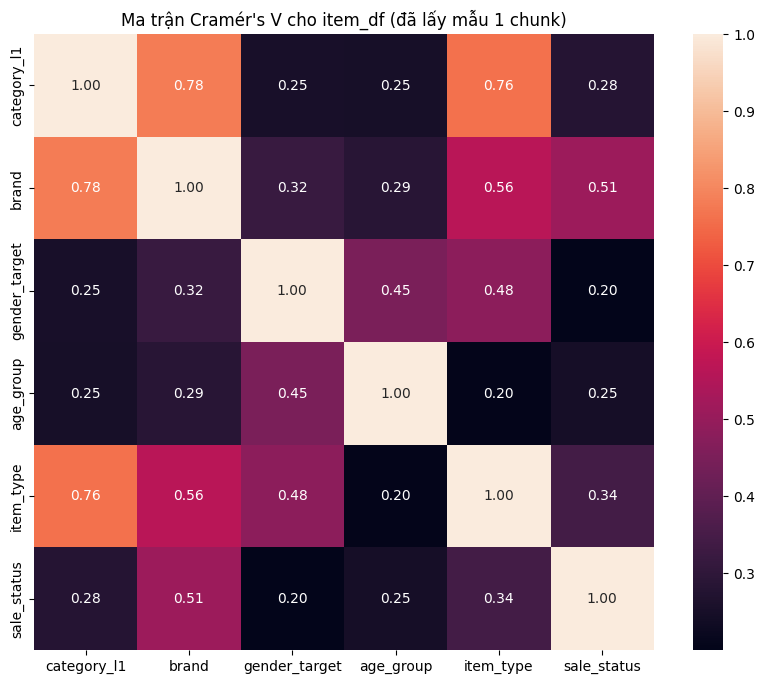

               category_l1     brand  gender_target  age_group  item_type  \
category_l1       1.000000  0.780305       0.253141   0.249429   0.761148   
brand             0.780305  1.000000       0.321458   0.286103   0.563091   
gender_target     0.253141  0.321458       1.000000   0.448626   0.483549   
age_group         0.249429  0.286103       0.448626   1.000000   0.204931   
item_type         0.761148  0.563091       0.483549   0.204931   1.000000   
sale_status       0.279251  0.512114       0.200183   0.245829   0.341914   

               sale_status  
category_l1       0.279251  
brand             0.512114  
gender_target     0.200183  
age_group         0.245829  
item_type         0.341914  
sale_status       1.000000  


In [17]:
# --- 1. Hàm Cramér's V (không đổi) ---
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.empty or confusion_matrix.shape[0] == 0 or confusion_matrix.shape[1] == 0:
        return 0.0
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0.0
    else:
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- 2. Các cột cần kiểm tra ---
categorical_cols = [
    'category_l1', 'brand', 'gender_target', 
    'age_group', 'item_type', 'sale_status'
]

# --- 3. Lấy mẫu ---
N_SAMPLE = 100_000
path_to_items = "../data/sales_pers.item_chunk_0.parquet"
df_one_chunk = pl.read_parquet(path_to_items)

total_count_in_chunk = len(df_one_chunk)
if total_count_in_chunk < N_SAMPLE:
    N_SAMPLE = total_count_in_chunk

df_sample_pd = df_one_chunk.sample(
    n=N_SAMPLE, 
    with_replacement=False, 
    shuffle=True
).to_pandas()

# --- 4. Tính toán ma trận ---
valid_cols = [col for col in categorical_cols if col in df_sample_pd.columns]
v_matrix = pd.DataFrame(
    np.zeros((len(valid_cols), len(valid_cols))),
    index=valid_cols,
    columns=valid_cols
)

for i in range(len(valid_cols)):
    for j in range(i, len(valid_cols)):
        col1 = valid_cols[i]
        col2 = valid_cols[j]
        
        if i == j:
            v = 1.0
        else:
            v = cramers_v(df_sample_pd[col1], df_sample_pd[col2])
            
        v_matrix.loc[col1, col2] = v
        v_matrix.loc[col2, col1] = v

# --- 5. Vẽ Heatmap ---
plt.figure(figsize=(10, 8))
sns.heatmap(
    v_matrix,
    annot=True,
    fmt='.2f'
)
plt.title("Ma trận Cramér's V cho item_df (đã lấy mẫu 1 chunk)")
plt.show()

print(v_matrix)

Task 3 (Phân tích tương quan) không cần áp dụng cho `item_df` vì:

- Không đủ biến số: `item_df` chỉ còn lại một cột số duy nhất là `price`. Không thể vẽ ma trận tương quan (heatmap) khi chỉ có một biến số.

- Đã xử lý dư thừa: Sự dư thừa giữa các cột danh mục (ví dụ: `category` và `category_id`) đã được giải quyết bằng quyết định chiến lược: Bỏ tất cả và chỉ giữ lại `category_l1`.

Các cột danh mục còn lại (như `brand`, `item_type`) không dư thừa 1-1 với `category_l1`. Do đó, `item_df` được coi là đã hoàn thành Task 3.

## **2. Data Frame: Purchase**

In [18]:
purchase_df.columns

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\991290049.py:1: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  purchase_df.columns


['timestamp',
 'item_id',
 'price',
 'date_key',
 'quantity',
 'customer_id',
 'channel',
 'payment',
 'location',
 'discount',
 'total_value']

Task 3 (Phân tích tương quan) không dẫn đến việc loại bỏ bất kỳ cột nào vì:

- Biến số (Numerical) đều quan trọng: Mặc dù price, quantity, và discount có thể tương quan, nhưng chúng không dư thừa. Mỗi cột đại diện cho một khía cạnh nghiệp vụ riêng biệt (giá trị, số lượng, khuyến mãi) và đều quan trọng để dự đoán hành vi.

- Biến danh mục (Categorical) không dư thừa: Các cột channel, payment, và location rõ ràng là độc lập và không có mối quan hệ 1-1.

## **3. Data Frame: User**

--- Đang đọc 1 file mẫu (Eager): ../data\sales_pers.user_chunk_0.parquet ---
--- Đang lấy 100,000 mẫu từ file chunk ---
Lấy mẫu và chuyển sang Pandas thành công.
--- Đang tính toán ma trận Cramér's V ---
Tính toán ma trận hoàn tất.
--- Đang vẽ Heatmap ---


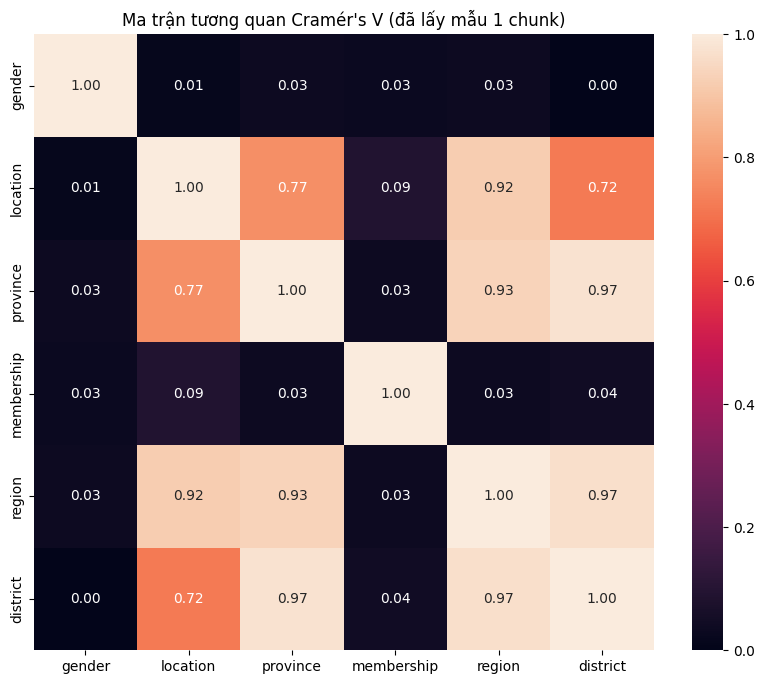

              gender  location  province  membership    region  district
gender      1.000000  0.011886  0.031943    0.030257  0.033601  0.000000
location    0.011886  1.000000  0.767096    0.088482  0.921605  0.719541
province    0.031943  0.767096  1.000000    0.034747  0.934049  0.974688
membership  0.030257  0.088482  0.034747    1.000000  0.032404  0.044057
region      0.033601  0.921605  0.934049    0.032404  1.000000  0.967886
district    0.000000  0.719541  0.974688    0.044057  0.967886  1.000000


In [19]:
# --- 1. Định nghĩa hàm tính Cramér's V ---
def cramers_v(x, y):
    """ Tính Cramér's V cho 2 cột categorical (pandas Series) """
    confusion_matrix = pd.crosstab(x, y)
    if confusion_matrix.empty or confusion_matrix.shape[0] == 0 or confusion_matrix.shape[1] == 0:
        return 0.0
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    if n == 0:
        return 0.0
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    if min((kcorr-1), (rcorr-1)) == 0:
        return 0.0
    else:
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- 2. Lấy danh sách các cột categorical ---
# (Chúng ta sẽ lấy các cột này từ file chunk)
categorical_cols = [
    'gender', 'location', 'province', 'membership', 
    'region', 'district'
]

# --- 3. LẤY MẪU (BẰNG CÁCH ĐỌC 1 FILE CHUNK) ---
N_SAMPLE = 100_000
df_sample_pd = None  # DataFrame Pandas cuối cùng

try:
    path_to_users = "../data/sales_pers.user_chunk_*.parquet"
    file_list = glob.glob(path_to_users)
    
    if not file_list:
        print("Lỗi: Không tìm thấy file nào ở 'data/sales_pers.user_chunk_*.parquet'")
        sys.exit(1) # Dừng nếu không tìm thấy file
        
    # Lấy file đầu tiên làm mẫu
    sample_file = file_list[0]
    print(f"--- Đang đọc 1 file mẫu (Eager): {sample_file} ---")
    
    # Đọc EAGER (pl.read_parquet) thay vì LAZY (pl.scan_parquet)
    df_one_chunk = pl.read_parquet(sample_file)
    
    # Kiểm tra xem file chunk có đủ 100k dòng không
    total_count_in_chunk = len(df_one_chunk)
    if total_count_in_chunk < N_SAMPLE:
        print(f"Cảnh báo: File chunk chỉ có {total_count_in_chunk:,.0f} dòng. Lấy toàn bộ chunk.")
        N_SAMPLE = total_count_in_chunk
        
    print(f"--- Đang lấy {N_SAMPLE:,.0f} mẫu từ file chunk ---")
    
    # Lấy mẫu từ Eager DataFrame (cách này luôn hoạt động)
    df_sample = df_one_chunk.sample(
        n=N_SAMPLE, 
        with_replacement=False, 
        shuffle=True
    )
    
    # Chuyển sang Pandas để tính toán
    df_sample_pd = df_sample.to_pandas()
    print("Lấy mẫu và chuyển sang Pandas thành công.")

except Exception as e:
    print(f"Lỗi nghiêm trọng khi lấy mẫu: {e}")
    print("Vui lòng kiểm tra lại đường dẫn file. Đang dừng thực thi.")

# --- 4. Tính toán ma trận Cramér's V ---
if df_sample_pd is not None:
    print("--- Đang tính toán ma trận Cramér's V ---")
    
    # Lọc lại danh sách cột (chỉ lấy các cột tồn tại trong file)
    valid_cols = [col for col in categorical_cols if col in df_sample_pd.columns]
    
    v_matrix = pd.DataFrame(
        np.zeros((len(valid_cols), len(valid_cols))),
        index=valid_cols,
        columns=valid_cols
    )

    for i in range(len(valid_cols)):
        for j in range(i, len(valid_cols)):
            col1 = valid_cols[i]
            col2 = valid_cols[j]
            
            if i == j:
                v = 1.0
            else:
                # df_sample_pd đã được định nghĩa
                v = cramers_v(df_sample_pd[col1], df_sample_pd[col2])
                
            v_matrix.loc[col1, col2] = v
            v_matrix.loc[col2, col1] = v # Điền đối xứng

    print("Tính toán ma trận hoàn tất.")

    # --- 5. Vẽ Heatmap ---
    print("--- Đang vẽ Heatmap ---")
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        v_matrix,
        annot=True,    
        fmt='.2f'       
    )
    plt.title("Ma trận tương quan Cramér's V (đã lấy mẫu 1 chunk)")
    plt.show()

    print(v_matrix)

else:
    print("\nKhông thể tiếp tục tính toán do lỗi ở bước lấy mẫu.")

In [20]:
user_df.filter(
    (pl.col("province") == "Hồ Chí Minh") & (pl.col("region") == "Bắc Trung Bộ")
).collect()

customer_id,gender,location,province,membership,timestamp,region,district
i32,str,i32,str,str,i64,str,str
664031,"""Nữ""",620,"""Hồ Chí Minh""","""Standard""",1466155238,"""Bắc Trung Bộ""","""5"""
660858,"""Nữ""",664,"""Hồ Chí Minh""","""Standard""",1465757305,"""Bắc Trung Bộ""","""6"""
1357570,"""Nữ""",441,"""Hồ Chí Minh""","""Standard""",1517157428,"""Bắc Trung Bộ""","""7"""
1808915,"""Nữ""",119,"""Hồ Chí Minh""","""Standard""",1536783192,"""Bắc Trung Bộ""","""2"""
2316559,"""Nữ""",423,"""Hồ Chí Minh""","""Standard""",1557051406,"""Bắc Trung Bộ""","""Bình Chánh"""
…,…,…,…,…,…,…,…
6345883,"""Nữ""",324,"""Hồ Chí Minh""","""Standard""",1680628904,"""Bắc Trung Bộ""","""7"""
6439332,"""Nữ""",141,"""Hồ Chí Minh""","""Standard""",1683559830,"""Bắc Trung Bộ""","""12"""
6897199,"""Nữ""",935,"""Hồ Chí Minh""","""Standard""",1697720738,"""Bắc Trung Bộ""","""Thủ Đức"""


Nhóm phát hiện ra có 71 rows có giá trị Hồ Chí Minh ở Bắc Trung Bộ, tiến hành thay thế Bắc Trung Bộ thành Đông Nam Bộ


In [21]:
user_df = user_df.with_columns(
    pl.when(pl.col("province") == "Hồ Chí Minh")  
      .then(pl.lit("Đông Nam Bộ"))                 
      .otherwise(pl.col("region"))                
      .alias("region")
)

#### Nhận xét từ Heatmap (Cramér's V)
Heatmap cho thấy một mối tương quan cực kỳ cao, gần như tuyệt đối, giữa các cột vị trí:

- (`district`, `province`) = 0.98

- (`district`, `region`) = 0.97

- (`province`, `region`) = 0.93

- (`location`, ...) cũng cho thấy tương quan rất cao (0.80+).

Những con số này không phải là 1.00 chính là vì 71 dòng lỗi (Hồ Chí Minh ở Bắc Trung Bộ) mà bạn đã phát hiện. Điều này chứng minh hai điều:

Dư thừa (Redundant): Các cột này bị đa cộng tuyến (multicollinearity) nghiêm trọng. Biết `district` gần như cho phép dự đoán 100% `province` và `region`.

Không đáng tin cậy (Unreliable): Các cột `province` và `region` đã được chứng minh là chứa lỗi.

#### Phương pháp xử lý
- GIỮ:

  - `district`: Cột này có độ chi tiết tốt nhất và đáng tin cậy nhất. Đây sẽ là đặc trưng vị trí "vàng" của chúng ta.

- BỎ (DROP):

  - `province`: Dư thừa (98%) so với `district`.

  - `region`: Dư thừa (97%) VÀ đã được xác nhận là chứa lỗi (unreliable).

  - `location`: Tương quan rất cao (0.80+) và quá chi tiết (ID cửa hàng), giữ lại có thể gây overfitting (mô hình học thuộc lòng ID thay vì khu vực).

In [22]:
cols_to_drop_redundant = [
    "location",  
    "region",
    "province"    
]

user_df = user_df.drop(cols_to_drop_redundant)

print("Các cột còn lại trong user_df:")
print(user_df.columns)

Các cột còn lại trong user_df:
['customer_id', 'gender', 'membership', 'timestamp', 'district']


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3668733875.py:10: PerformanceWarning: Determining the column names of a LazyFrame requires resolving its schema, which is a potentially expensive operation. Use `LazyFrame.collect_schema().names()` to get the column names without this warning.
  print(user_df.columns)


## **Task 4: Chuẩn hóa dữ liệu (nếu có), biến đổi dữ liệu**

## **1. Data Frame: Item**

#### 1. Vấn đề: Số lượng giá trị duy nhất cao 
* Phân tích cho thấy cột `brand` và `item_type` có rất nhiều giá trị unique.
* Phân phối bị lệch nặng
* Nếu giữ nguyên mô hình sẽ bị "nhiễu" và **overfitting** vào các dữ liệu ít xuất hiện.

#### 2. Giải pháp: Giảm số lượng (Grouping Rare Labels)
* Chúng ta sẽ **giảm số lượng giá trị duy nhất** bằng cách gộp các thương hiệu hiếm lại.
* **Hành động:** Đặt một ngưỡng (ví dụ: `COUNT_THRESHOLD = 50`). Bất kỳ giá trị nào xuất hiện **dưới 50 lần** sẽ được nhóm lại thành một danh mục duy nhất là **"Other_*"**.

### `Brand`

--- 🛠️ Task 4 (Sửa đổi): Đang tính tần suất giao dịch (Join) ---
--- 📊 Đang phân tích 'brand' (theo giao dịch) ---
Top 300 Brand theo Giao dịch:
shape: (300, 2)
┌───────────────┬───────────────────┐
│ brand         ┆ transaction_count │
│ ---           ┆ ---               │
│ str           ┆ u32               │
╞═══════════════╪═══════════════════╡
│ Animo         ┆ 3907601           │
│ HOFF          ┆ 1145817           │
│ Takato        ┆ 825886            │
│ Unknown_brand ┆ 751576            │
│ Cây Thị       ┆ 647871            │
│ …             ┆ …                 │
│ Merries       ┆ 13902             │
│ Daesang       ┆ 13828             │
│ Skater        ┆ 13555             │
│ Kaneshichi    ┆ 13525             │
│ Baby          ┆ 13327             │
└───────────────┴───────────────────┘


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3796940994.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_300_brands.head(30).to_pandas(), y="brand", x="transaction_count", palette="viridis")


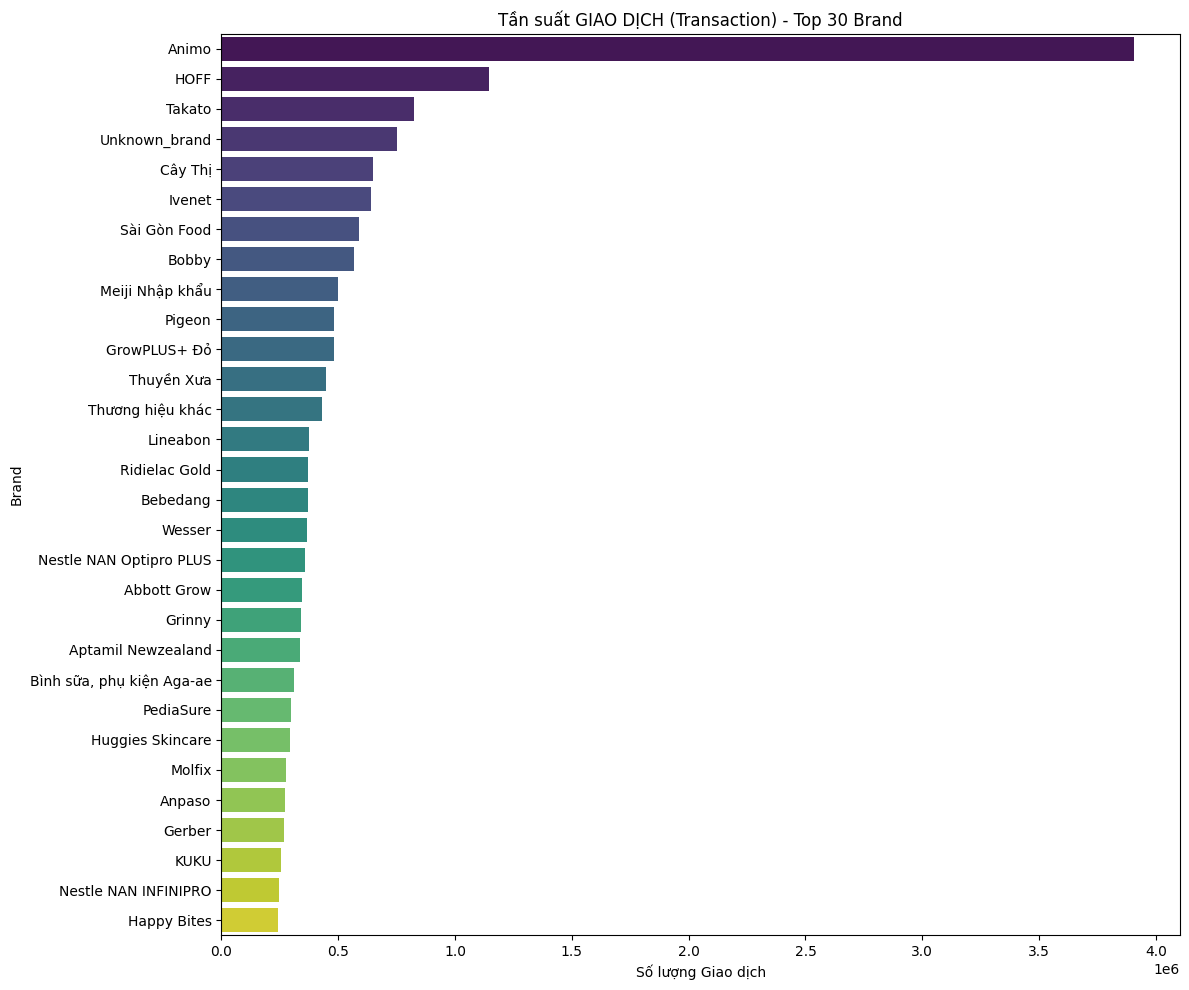


--- 📊 Đang phân tích 'item_type' (theo giao dịch) ---
Top 30 Item Type theo Giao dịch:
                               item_type  transaction_count
0                         Sữa bột cho bé            4355945
1                   Bánh, kẹo dinh dưỡng            2311479
2                                Tã quần            2033241
3                            Bánh ăn dặm            1977227
4                      Unknown_item_type            1574089
5                   Thức uống dinh dưỡng            1283196
6                                   Cháo            1206086
7                Sữa chua, sữa chua uống            1145960
8                                 Tã dán             963833
9                               Bình sữa             940598
10                       Sữa bột pha sẵn             848693
11                       Đồ chơi sơ sinh             757003
12                            Bộ quần áo             740358
13                      Sữa tắm gội 2in1             735021
14          

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3796940994.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_30_items_pd, y="item_type", x="transaction_count", palette="viridis")


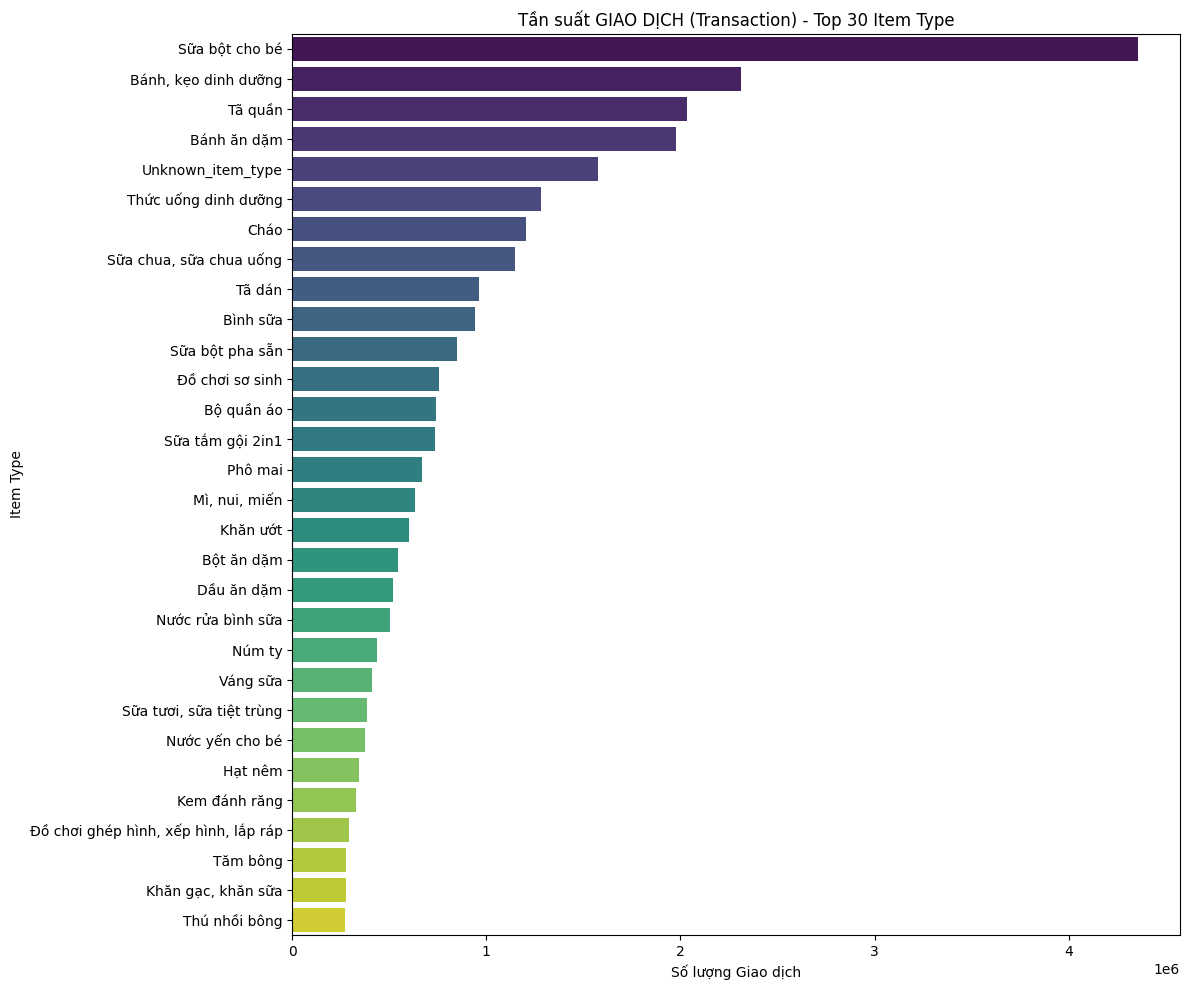

In [23]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

# (Giả sử 'purchase_df' và 'item_df' là LazyFrames đã xử lý Task 1-3)
print("--- 🛠️ Task 4 (Sửa đổi): Đang tính tần suất giao dịch (Join) ---")

# Join
joined_df = purchase_df.join(
    item_df.select("item_id", "brand", "item_type"),
    on="item_id",
    how="inner"
)

# --- Phân tích Brand (theo giao dịch) ---
print("--- 📊 Đang phân tích 'brand' (theo giao dịch) ---")
brand_trans_counts = joined_df.group_by("brand").agg(
    pl.len().alias("transaction_count")
).sort("transaction_count", descending=True)

# Lấy Top 300 (thay vì 30) để xem "đuôi dài"
top_300_brands = brand_trans_counts.head(300).collect()
print("Top 300 Brand theo Giao dịch:")
print(top_300_brands)

# Vẽ biểu đồ (vẫn chỉ vẽ Top 30 cho dễ nhìn)
plt.figure(figsize=(12, 10))
sns.barplot(data=top_300_brands.head(30).to_pandas(), y="brand", x="transaction_count", palette="viridis")
plt.title("Tần suất GIAO DỊCH (Transaction) - Top 30 Brand")
plt.xlabel("Số lượng Giao dịch")
plt.ylabel("Brand")
plt.tight_layout()
plt.show()

# --- Phân tích Item Type (theo giao dịch) ---
print("\n--- 📊 Đang phân tích 'item_type' (theo giao dịch) ---")
item_type_trans_counts = joined_df.group_by("item_type").agg(
    pl.len().alias("transaction_count")
).sort("transaction_count", descending=True)

# (In Top 30 cho item_type)
top_30_items_pd = item_type_trans_counts.head(30).collect().to_pandas()
print("Top 30 Item Type theo Giao dịch:")
print(top_30_items_pd)

plt.figure(figsize=(12, 10))
sns.barplot(data=top_30_items_pd, y="item_type", x="transaction_count", palette="viridis")
plt.title("Tần suất GIAO DỊCH (Transaction) - Top 30 Item Type")
plt.xlabel("Số lượng Giao dịch")
plt.ylabel("Item Type")
plt.tight_layout()
plt.show()

 **1. Phân tích `brand` (Thương hiệu)**

* **Phân phối:** Dữ liệu có "đuôi dài" (long tail) rất rõ rệt. Top 30 brand có trên 243,000 giao dịch. Tuy nhiên, nhóm nhận thấy các brand "tầm trung" (ví dụ: brand thứ 300) vẫn có số lượng giao dịch đáng kể (khoảng 10,000).
* **Ngưỡng đề xuất:** `BRAND_TRANS_THRESHOLD = 10000`
* **Lý do:** Ngưỡng 10,000 sẽ giữ lại khoảng 300 brand hàng đầu, đảm bảo các brand tầm trung quan trọng được giữ lại. Nó sẽ chỉ gộp các brand *thực sự hiếm* (dưới 10k giao dịch) vào nhóm "Other\_Brand", giúp giảm số lượng (cardinality) một cách hợp lý.

**2. Phân tích `item_type` (Loại sản phẩm)**

* **Phân phối:** `item_type` cũng có "đuôi dài" tương tự. Top 30 có trên 263,000 giao dịch.
* **Ngưỡng đề xuất:** `ITEM_TYPE_TRANS_THRESHOLD = 10000`
* **Lý do:** Tương tự như `brand`, ngưỡng 10,000 (hoặc có thể cao hơn một chút, ví dụ 20,000, tùy vào phân tích) sẽ giữ lại tất cả các `item_type` quan trọng và "tầm trung", đồng thời chỉ gộp các loại sản phẩm thực sự hiếm.

In [24]:
import polars as pl

# (Giả sử 'purchase_df' và 'item_df' là LazyFrames từ cell trước)
# (Và 'joined_df' cũng từ cell trước)

# --- 1. Đặt ngưỡng (Dựa trên phân tích mới) ---
BRAND_TRANS_THRESHOLD = 10000      
ITEM_TYPE_TRANS_THRESHOLD = 10000  

# --- 2. Lấy danh sách brand phổ biến (từ 'joined_df') ---
print(f"--- 🛠️ Đang gộp 'brand' (ngưỡng > {BRAND_TRANS_THRESHOLD}) ---")
top_brands_list = joined_df.lazy().group_by("brand").agg(
    pl.len().alias("count")
).filter(
    (pl.col("count") > BRAND_TRANS_THRESHOLD) | 
    (pl.col("brand") == "Unknown_brand")
).select("brand").collect().to_series()

# --- 3. Lấy danh sách item_type phổ biến (từ 'joined_df') ---
print(f"--- 🛠️ Đang gộp 'item_type' (ngưỡng > {ITEM_TYPE_TRANS_THRESHOLD}) ---")
top_items_list = joined_df.lazy().group_by("item_type").agg(
    pl.len().alias("count")
).filter(
    (pl.col("count") > ITEM_TYPE_TRANS_THRESHOLD) | 
    (pl.col("item_type") == "Unknown_item_type")
).select("item_type").collect().to_series()

print(f"Số brand phổ biến (theo giao dịch): {len(top_brands_list)}")
print(f"Số item_type phổ biến (theo giao dịch): {len(top_items_list)}")

# --- 4. Áp dụng grouping MỚI này vào 'item_df' ---
item_df = item_df.with_columns(
    pl.when(
        pl.col("brand").is_in(top_brands_list)
    )
    .then(pl.col("brand")) 
    .otherwise(pl.lit("Other_Brand")) 
    .alias("brand"),
    
    pl.when(
        pl.col("item_type").is_in(top_items_list)
    )
    .then(pl.col("item_type")) 
    .otherwise(pl.lit("Other_item_type")) 
    .alias("item_type")
)

print(f"--- ✅ Đã gộp 'brand' và 'item_type' trong 'item_df' ---")

# (Kiểm tra kết quả)
print("\nCác 'brand' còn lại:")
print(item_df.lazy().group_by("brand").len().sort("len", descending=True).collect())
print("\nCác 'item_type' còn lại:")
print(item_df.lazy().group_by("item_type").len().sort("len", descending=True).collect())

--- 🛠️ Đang gộp 'brand' (ngưỡng > 10000) ---
--- 🛠️ Đang gộp 'item_type' (ngưỡng > 10000) ---
Số brand phổ biến (theo giao dịch): 328
Số item_type phổ biến (theo giao dịch): 129
--- ✅ Đã gộp 'brand' và 'item_type' trong 'item_df' ---

Các 'brand' còn lại:
shape: (329, 2)
┌──────────────────────┬──────┐
│ brand                ┆ len  │
│ ---                  ┆ ---  │
│ str                  ┆ u32  │
╞══════════════════════╪══════╡
│ Animo                ┆ 8149 │
│ Unknown_brand        ┆ 5480 │
│ CF (ConCung Fashion) ┆ 5426 │
│ Other_Brand          ┆ 4025 │
│ Thương hiệu khác     ┆ 607  │
│ …                    ┆ …    │
│ BabyPlus             ┆ 1    │
│ Children's Health    ┆ 1    │
│ ColosBaby            ┆ 1    │
│ CORIS                ┆ 1    │
│ Johnson's            ┆ 1    │
└──────────────────────┴──────┘

Các 'item_type' còn lại:
shape: (130, 2)
┌───────────────────┬──────┐
│ item_type         ┆ len  │
│ ---               ┆ ---  │
│ str               ┆ u32  │
╞═══════════════════╪═════

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3978942748.py:52: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  print(item_df.lazy().group_by("brand").len().sort("len", descending=True).collect())
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3978942748.py:54: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  print(item_df.lazy().group_by("item_type").len().sort("len", descending=True).collect())


## **2. Data Frame: Purchase**

#### 1. Vấn đề
* **Biến Thời gian (Time):**
  
    * Các cột `timestamp` (i64) và `date_key` (i32) đang ở dạng số thô.
    * Mô hình không thể hiểu được các "pattern" thời gian (như *giờ trong ngày*, *thứ trong tuần*, *mùa vụ*). Chúng là vô dụng cho Feature Engineering nếu ở dạng này.
    * Cột location (ID cửa hàng) có khả năng cao có số lượng giá trị duy nhất rất lớn (high cardinality).
    * Nhiều cửa hàng hiếm (ít giao dịch) sẽ gây nhiễu (noise) và overfitting, tương tự như vấn đề với brand và item_type.

### 2. Giải pháp

* **Giải pháp cho Vấn đề:**
    * **Biến đổi (Transform):** Chúng ta sẽ **biến đổi** cột `timestamp` (Unix i64) sang định dạng **`datetime`** chuẩn.
    * Đây là bước *bắt buộc* để chuẩn bị cho **Task 5 (Feature Engineering)**, cho phép chúng ta rút trích các đặc trưng thời gian quan trọng.

* **Giải pháp cho Vấn đề `location`:**
    * Giảm số lượng (Grouping): Chúng ta sẽ kiểm tra tần suất của location và gộp các ID cửa hàng hiếm (ví dụ: xuất hiện < 1000 lần) vào một giá trị đại diện (ví dụ: 0 hoặc -1) để giảm nhiễu.

In [25]:
purchase_df = purchase_df.with_columns(
    (pl.col("timestamp") * 1000).cast(
        pl.Datetime(time_unit="ms")
    ).alias("datetime"),
    
    pl.col("date_key").cast(pl.Utf8).str.strptime(
        pl.Date, "%Y%m%d"
    ).alias("date")
)

# In 5 dòng đầu để xem 2 cột mới
print(purchase_df.head(5).collect().select("timestamp", "datetime", "date_key", "date"))

purchase_df = purchase_df.drop(
    ["timestamp", "date_key"]
)

print("Đã drop 'timestamp' và 'date_key'.")

shape: (5, 4)
┌────────────┬─────────────────────┬──────────┬────────────┐
│ timestamp  ┆ datetime            ┆ date_key ┆ date       │
│ ---        ┆ ---                 ┆ ---      ┆ ---        │
│ i64        ┆ datetime[ms]        ┆ i32      ┆ date       │
╞════════════╪═════════════════════╪══════════╪════════════╡
│ 1735064221 ┆ 2024-12-24 18:17:01 ┆ 20241224 ┆ 2024-12-24 │
│ 1735068481 ┆ 2024-12-24 19:28:01 ┆ 20241224 ┆ 2024-12-24 │
│ 1735069843 ┆ 2024-12-24 19:50:43 ┆ 20241224 ┆ 2024-12-24 │
│ 1735069779 ┆ 2024-12-24 19:49:39 ┆ 20241224 ┆ 2024-12-24 │
│ 1735379373 ┆ 2024-12-28 09:49:33 ┆ 20241228 ┆ 2024-12-28 │
└────────────┴─────────────────────┴──────────┴────────────┘
Đã drop 'timestamp' và 'date_key'.


In [26]:
print("--- Tần suất TOP 20 'location' (Để quyết định ngưỡng) ---")
top_20_locations = purchase_df.lazy().group_by("location").agg(
    pl.len().alias("count")
).sort("count", descending=True).head(20).collect()

print(top_20_locations)

--- Tần suất TOP 20 'location' (Để quyết định ngưỡng) ---
shape: (20, 2)
┌──────────┬────────┐
│ location ┆ count  │
│ ---      ┆ ---    │
│ i32      ┆ u32    │
╞══════════╪════════╡
│ 645      ┆ 312956 │
│ 88       ┆ 201016 │
│ 658      ┆ 188006 │
│ 724      ┆ 173188 │
│ 340      ┆ 160647 │
│ …        ┆ …      │
│ 151      ┆ 125553 │
│ 443      ┆ 125401 │
│ 106      ┆ 122349 │
│ 252      ┆ 121722 │
│ 556      ┆ 119828 │
└──────────┴────────┘


In [27]:
# --- 1. Đặt ngưỡng và ID thay thế ---
COUNT_THRESHOLD = 10000 
OTHER_LOCATION_ID = 0  # ID cho "Other"

# --- 2. Lấy danh sách location phổ biến ---
top_locations_list = purchase_df.lazy().group_by("location").agg(
    pl.len().alias("count")
).filter(
    pl.col("count") > COUNT_THRESHOLD
).select("location").collect().to_series()

# --- 3. Áp dụng Gộp ---
purchase_df = purchase_df.with_columns(
    pl.when(
        pl.col("location").is_in(top_locations_list)
    )
    .then(pl.col("location")) 
    .otherwise(pl.lit(OTHER_LOCATION_ID)) 
    .alias("location")
)

print(f"Đã gộp các location hiếm vào ID {OTHER_LOCATION_ID}.")

Đã gộp các location hiếm vào ID 0.


## **3. Data Frame: User**

#### 1. Vấn đề 1: Chuẩn hóa Tên (Tỉnh/Quận)

* **`district` (Quận/Huyện):** Đối với cột `district`, **nhóm quyết định giữ nguyên** các tiền tố ("Quận", "Huyện", "Thị xã"). Lý do là các tiền tố này là một phần quan trọng của tên và giúp phân biệt các địa danh (ví dụ: "Thị xã Gò Công" và "Huyện Gò Công Đông"). Bỏ đi sẽ gây nhầm lẫn dữ liệu.

#### 2. Vấn đề 2: Giảm số lượng giá trị duy nhất (Grouping)

* **Vấn đề:** Cột `district`  (ngay cả sau khi chuẩn hóa) có số lượng giá trị duy nhất cao (high cardinality), với nhiều địa danh hiếm (ít user).
* **Giải pháp:** Để giảm nhiễu và tránh overfitting, **nhóm sẽ áp dụng kỹ thuật "grouping"** (tương tự như `brand`) để gộp các địa danh hiếm (ví dụ: có dưới 500 user) vào một nhóm chung là **"Other_District"**.

#### 3. Vấn đề 3: Biến đổi Thời gian

* **Vấn đề:** Cột `timestamp` (thời điểm tạo tài khoản) đang ở dạng số Unix (i64), mô hình không thể hiểu được.
* **Giải pháp:** **Nhóm sẽ biến đổi `timestamp`** sang định dạng `datetime` chuẩn (đặt tên là `account_creation_date`) để chuẩn bị cho Task 5 (ví dụ: tính "tuổi" tài khoản). Cột `timestamp` gốc sau đó sẽ được loại bỏ.

In [28]:
user_df = user_df.with_columns(
    (pl.col("timestamp") * 1000).cast(
        pl.Datetime(time_unit="ms")
    ).alias("account_creation_date")
    
).drop(
    "timestamp"
)

print("Đã chuẩn hóa 'province' và biến đổi 'timestamp' -> 'account_creation_date'.")

Đã chuẩn hóa 'province' và biến đổi 'timestamp' -> 'account_creation_date'.


--- Tổng số district unique: 1,339 ---


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\1762144764.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_30_districts_pd, y="district", x="count", palette="viridis")


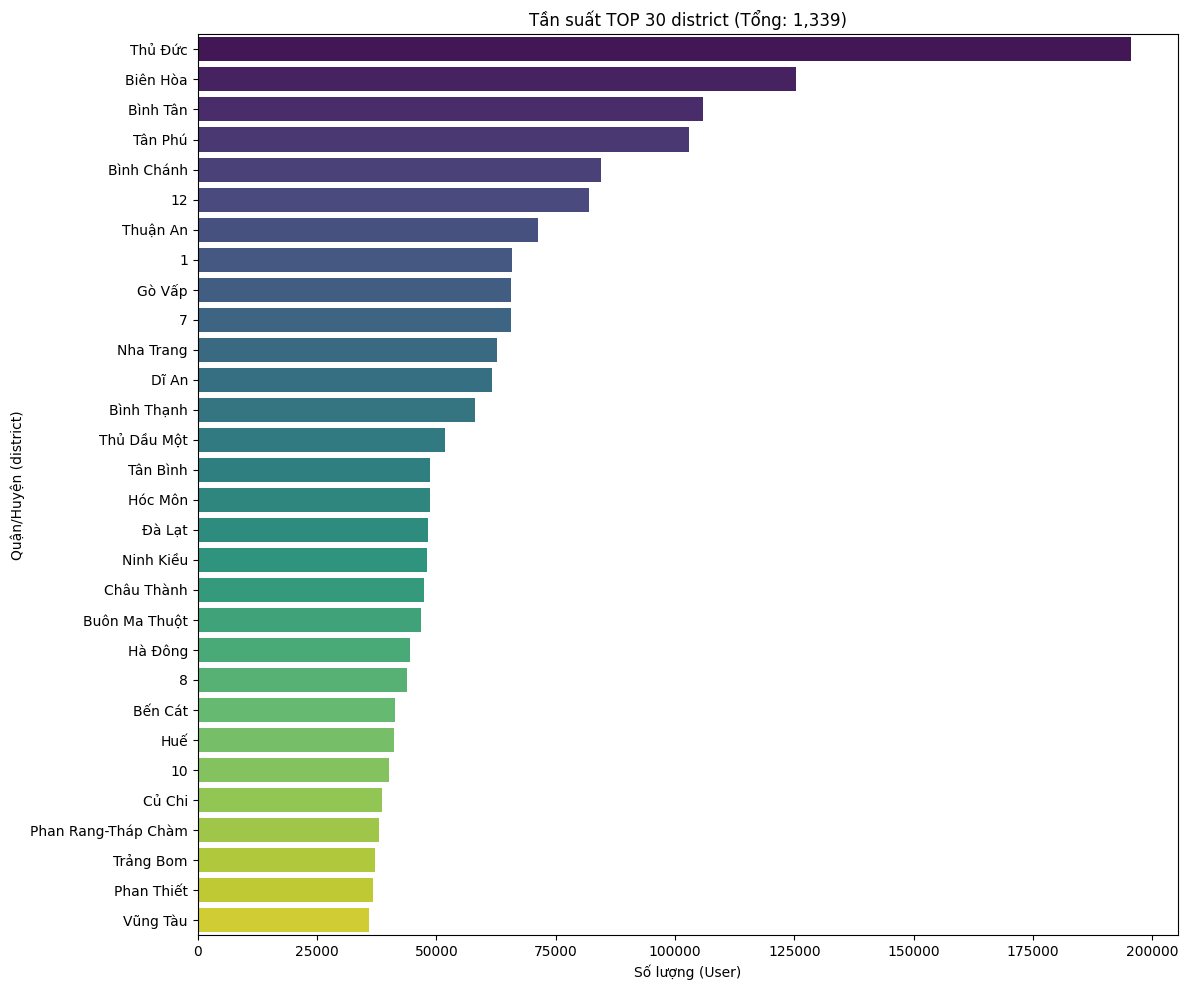

In [29]:
# --- Phân tích District ---
total_unique_districts = user_df.lazy().select(
    pl.col("district").n_unique()
).collect().item()
print(f"--- Tổng số district unique: {total_unique_districts:,.0f} ---")

top_30_districts_pd = user_df.lazy().group_by("district").agg(
    pl.len().alias("count")
).sort("count", descending=True).head(30).collect().to_pandas()

plt.figure(figsize=(12, 10))
sns.barplot(data=top_30_districts_pd, y="district", x="count", palette="viridis")
plt.title(f"Tần suất TOP 30 district (Tổng: {total_unique_districts:,.0f})")
plt.xlabel("Số lượng (User)")
plt.ylabel("Quận/Huyện (district)")
plt.tight_layout()
plt.show()

In [30]:
DISTRICT_THRESHOLD = 5000  
PROVINCE_THRESHOLD = 10000 

# --- 2. Lấy danh sách phổ biến ---
top_districts_list = user_df.lazy().group_by("district").agg(
    pl.len().alias("count")
).filter(
    pl.col("count") > DISTRICT_THRESHOLD
).select("district").collect().to_series()

print(f"Số district phổ biến (> {DISTRICT_THRESHOLD}): {len(top_districts_list)}")

# --- 3. Áp dụng grouping ---
user_df = user_df.with_columns(
    pl.when(
        pl.col("district").is_in(top_districts_list)
    )
    .then(pl.col("district")) 
    .otherwise(pl.lit("Other_District")) 
    .alias("district"),
)

print("\n--- 'district' sau khi gộp ---")
print(user_df.lazy().group_by("district").len().sort("len", descending=True).collect())

Số district phổ biến (> 5000): 202

--- 'district' sau khi gộp ---
shape: (203, 2)
┌────────────────┬────────┐
│ district       ┆ len    │
│ ---            ┆ ---    │
│ str            ┆ u32    │
╞════════════════╪════════╡
│ Other_District ┆ 459562 │
│ Thủ Đức        ┆ 195601 │
│ Biên Hòa       ┆ 125390 │
│ Bình Tân       ┆ 105858 │
│ Tân Phú        ┆ 102835 │
│ …              ┆ …      │
│ Krông Bông     ┆ 5194   │
│ Sầm Sơn        ┆ 5177   │
│ Ea Súp         ┆ 5104   │
│ Kinh Môn       ┆ 5033   │
│ Lai Châu       ┆ 5009   │
└────────────────┴────────┘


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\1105602485.py:24: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  print(user_df.lazy().group_by("district").len().sort("len", descending=True).collect())


## **Task 5: Nhóm hãy suy nghĩ xem, với bài toán dự đoán mua hàng, ta có thể tạo mới những đặc trưng nào. Sau đó tiến hành rút trích thêm các đặc trưng. Task này rất quan trọng vì ảnh hưởng hiệu quả của hệ thống.**

#### **Thống kê sản phẩm hay mua chung (Đồng xuất hiện)**

* **Ý tưởng:** Nhóm nhận thấy việc khách hàng mua nhiều sản phẩm trong một lần có thể là một tín hiệu dự đoán mạnh mẽ.
* **Mục tiêu:** Xác định và đếm tần suất các **cặp sản phẩm (co-occurrence)** thường xuyên xuất hiện trong cùng một giao dịch.
* **Phương pháp:**
    1.  Nhóm định nghĩa một "giao dịch" là các giao dịch có chung `customer_id` và `datetime`.
    2.  Tiến hành tự join (self-join) bảng `purchase_df` để tìm các cặp `(item_1, item_2)` trong cùng giao dịch.
    3.  Đếm số lần xuất hiện của mỗi cặp để tìm ra các sản phẩm hay được mua chung nhất.

In [31]:
print("--- Task A (Bước 1): Đang tạo các cặp sản phẩm (Co-occurrence) ---")
(
    purchase_df.lazy()
    .join(
        purchase_df.lazy(), 
        on=['customer_id', 'datetime'] # Join trên cùng user và thời điểm
    )
    .filter(
        pl.col('item_id') < pl.col('item_id_right') # Tránh (A,A) và (B,A)
    )
    .select([
        pl.col('item_id').alias('item_1'),
        pl.col('item_id_right').alias('item_2')
    ])
    .sink_parquet('intermediate_pairs.parquet', compression='zstd')
)

--- Task A (Bước 1): Đang tạo các cặp sản phẩm (Co-occurrence) ---


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3854329511.py:15: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  .sink_parquet('intermediate_pairs.parquet', compression='zstd')


In [32]:
final_co_occurrence = (
    pl.scan_parquet('intermediate_pairs.parquet')
    .group_by(['item_1', 'item_2'])
    .agg(pl.len().alias('#cooc'))
    .sort('#cooc', descending=True)
    .collect()
)

print("Top 20 sản phẩm hay mua chung:")
print(final_co_occurrence.head(20))

Top 20 sản phẩm hay mua chung:
shape: (20, 3)
┌───────────────┬───────────────┬───────┐
│ item_1        ┆ item_2        ┆ #cooc │
│ ---           ┆ ---           ┆ ---   │
│ str           ┆ str           ┆ u32   │
╞═══════════════╪═══════════════╪═══════╡
│ 2803000000011 ┆ 2803000000013 ┆ 78241 │
│ 2803000000012 ┆ 2803000000013 ┆ 53481 │
│ 2803000000011 ┆ 2803000000012 ┆ 52849 │
│ 2803000000010 ┆ 2803000000012 ┆ 34205 │
│ 2803000000010 ┆ 2803000000013 ┆ 32656 │
│ …             ┆ …             ┆ …     │
│ 1371000000002 ┆ 1371000000006 ┆ 24309 │
│ 1371000000001 ┆ 1371000000003 ┆ 24183 │
│ 1371000000004 ┆ 1371000000005 ┆ 23771 │
│ 0029250010002 ┆ 0029250010003 ┆ 23427 │
│ 1371000000003 ┆ 1371000000005 ┆ 23042 │
└───────────────┴───────────────┴───────┘


 Các `item_id` này hiện không thể đọc được. Để hiểu rõ hơn về nghiệp vụ, bước tiếp theo là join bảng final_co_occurrence này với item_df để lấy tên sản phẩm (`brand`, `item_type`) và xem chính xác "Sữa A" hay được mua cùng "Tã B".

In [33]:
# 1. Tải lại item_df GỐC (chỉ để tra cứu)
# (Chúng ta phải dùng bản gốc, trước khi gộp 'Other_Brand')
path_to_items = "../data/sales_pers.item_chunk_0.parquet"
item_df_original = pl.scan_parquet(path_to_items)

# 2. Chọn các cột cần tra cứu
item_details_df = item_df_original.select(
    "item_id", "brand", "item_type", "category_l1" 
)

# 3. Join lần 1 (cho item_1)
readable_cooc = final_co_occurrence.lazy().join(
    item_details_df.rename({"brand": "brand_1", "item_type": "item_type_1", "category_l1": "category_l1_1"}),
    left_on="item_1",
    right_on="item_id",
    how="left"
)

# 4. Join lần 2 (cho item_2)
readable_cooc = readable_cooc.join(
    item_details_df.rename({"brand": "brand_2", "item_type": "item_type_2", "category_l1": "category_l1_2"}),
    left_on="item_2",
    right_on="item_id",
    how="left"
)

# 5. Chọn cột cuối cùng và collect
final_readable_cooc = readable_cooc.select(
    "#cooc",
    "item_1", "brand_1", "item_type_1", "category_l1_1",
    "item_2", "brand_2", "item_type_2", "category_l1_2"
).sort("#cooc", descending=True).collect()

print("Top 20 sản phẩm hay mua chung (đã có tên GỐC):")
print(final_readable_cooc.head(20))

Top 20 sản phẩm hay mua chung (đã có tên GỐC):
shape: (20, 9)
┌───────┬─────────────┬─────────┬─────────────┬───┬────────────┬─────────┬────────────┬────────────┐
│ #cooc ┆ item_1      ┆ brand_1 ┆ item_type_1 ┆ … ┆ item_2     ┆ brand_2 ┆ item_type_ ┆ category_l │
│ ---   ┆ ---         ┆ ---     ┆ ---         ┆   ┆ ---        ┆ ---     ┆ 2          ┆ 1_2        │
│ u32   ┆ str         ┆ str     ┆ str         ┆   ┆ str        ┆ str     ┆ ---        ┆ ---        │
│       ┆             ┆         ┆             ┆   ┆            ┆         ┆ str        ┆ str        │
╞═══════╪═════════════╪═════════╪═════════════╪═══╪════════════╪═════════╪════════════╪════════════╡
│ 78241 ┆ 28030000000 ┆ HOFF    ┆ Sữa chua,   ┆ … ┆ 2803000000 ┆ HOFF    ┆ Sữa chua,  ┆ Thực phẩm  │
│       ┆ 11          ┆         ┆ sữa chua    ┆   ┆ 013        ┆         ┆ sữa chua   ┆ cho bé     │
│       ┆             ┆         ┆ uống        ┆   ┆            ┆         ┆ uống       ┆            │
│ 53481 ┆ 28030000000 ┆ HOFF 

In [34]:
import os

output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)
print(f"Thư mục '{output_dir}' đã sẵn sàng.")

Thư mục 'processed_data' đã sẵn sàng.


`price_segment`: Nhóm sẽ tạo một cột phân khúc giá (ví dụ: "low", "medium", "high") bằng cách sử dụng qcut (phân vị) trên cột `price`. Điều này giúp mô hình hiểu được các tầm giá sản phẩm thay vì chỉ nhìn vào giá trị số tuyệt đối.

In [35]:
item_df = item_df.with_columns(
    pl.col("price").qcut( # Sửa từ pl.qcut thành pl.col("price").qcut
        quantiles=[0.25, 0.5, 0.75],
        labels=["low", "medium", "high", "very_high"]
    ).alias("price_segment")
)

# 6. Sink (Lưu kết quả)
output_dir = "processed_data"
output_path = os.path.join(output_dir, "processed_item.parquet")
item_df.sink_parquet(output_path, compression='zstd')

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3980336186.py:11: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  item_df.sink_parquet(output_path, compression='zstd')


`discount_rate`: Nhóm sẽ tạo cột tỷ lệ giảm giá (discount / total_value). Đặc trưng này phản ánh "sức hút" của khuyến mãi (ví dụ: giảm 50%) tốt hơn nhiều so với giá trị `discount` (ví dụ: giảm 50,000đ).

In [36]:
purchase_df = purchase_df.with_columns(
    (pl.col("price") * pl.col("quantity")).alias("total_value")
)
purchase_df = purchase_df.with_columns(
    pl.when(pl.col("discount") > pl.col("total_value")).then(pl.col("total_value")).otherwise(pl.col("discount")).alias("discount")
)
purchase_df = purchase_df.with_columns(
    pl.when(pl.col("total_value") > 0)
      .then(pl.col("discount") / pl.col("total_value"))
      .otherwise(0)
      .alias("discount_rate")
).drop("total_value") # Bỏ total_value sau khi đã tính rate

# 6. Sink
output_path = os.path.join(output_dir, "processed_purchase.parquet")
purchase_df.sink_parquet(output_path, compression='zstd')

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\519865087.py:16: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  purchase_df.sink_parquet(output_path, compression='zstd')


`customer_tenure_days`: Nhóm sẽ tính "tuổi" của tài khoản (tính bằng ngày) bằng cách lấy (Hôm nay - `account_creation_date`). Đặc trưng này đo lường sự trung thành của khách hàng.

In [37]:
user_df = user_df.with_columns(
     (pl.lit(datetime.now()) - pl.col("account_creation_date"))
     .dt.total_days()
     .alias("customer_tenure_days")
)

# 8. Sink
output_path = os.path.join(output_dir, "processed_user.parquet")
user_df.sink_parquet(output_path, compression='zstd')

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\3806905541.py:9: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  user_df.sink_parquet(output_path, compression='zstd')


In [38]:
# (Giả sử 'purchase_df' là LazyFrame của bạn đã qua Task 4)
print("--- Task 5: Đang kiểm tra tính duy nhất của 'location' trong purchase_df ---")

# Đếm số location (đã gộp) duy nhất cho mỗi customer_id
location_check = purchase_df.lazy().group_by("customer_id").agg(
    pl.col("location").n_unique().alias("unique_locations_count")
).filter(
    pl.col("unique_locations_count") > 1 # Tìm user có nhiều hơn 1 location
)

# Lấy 10 ví dụ
result = location_check.head(10).collect()

if result.is_empty():
    print("--- Kết quả: Giả thuyết 1 ĐÚNG ---")
    print("Mỗi user chỉ mua ở 1 location. Cột này có vẻ là 'Vị trí đăng ký'.")
else:
    print("--- Kết quả: Giả thuyết 2 ĐÚNG ---")
    print("Phát hiện user mua hàng ở nhiều location khác nhau.")
    print("Cột này là 'Vị trí GIAO DỊCH', KHÔNG dư thừa.")
    print("\nVí dụ (User mua ở nhiều nơi):")
    print(result)

--- Task 5: Đang kiểm tra tính duy nhất của 'location' trong purchase_df ---


C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_26812\1855101347.py:12: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  result = location_check.head(10).collect()


--- Kết quả: Giả thuyết 2 ĐÚNG ---
Phát hiện user mua hàng ở nhiều location khác nhau.
Cột này là 'Vị trí GIAO DỊCH', KHÔNG dư thừa.

Ví dụ (User mua ở nhiều nơi):
shape: (10, 2)
┌─────────────┬────────────────────────┐
│ customer_id ┆ unique_locations_count │
│ ---         ┆ ---                    │
│ i32         ┆ u32                    │
╞═════════════╪════════════════════════╡
│ 6186736     ┆ 4                      │
│ 7456361     ┆ 2                      │
│ 889539      ┆ 7                      │
│ 5285672     ┆ 2                      │
│ 6693741     ┆ 2                      │
│ 3876564     ┆ 4                      │
│ 286814      ┆ 2                      │
│ 7252917     ┆ 2                      │
│ 343719      ┆ 2                      │
│ 2491971     ┆ 4                      │
└─────────────┴────────────────────────┘
